# 12. 언더피팅/오버피팅 소개

In [1]:
!wget -N https://github.com/DNRY/tfopt/raw/main/notebooks/helper.py

--2022-10-08 16:51:11--  https://github.com/DNRY/tfopt/raw/main/notebooks/helper.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DNRY/tfopt/main/notebooks/helper.py [following]
--2022-10-08 16:51:11--  https://raw.githubusercontent.com/DNRY/tfopt/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7133 (7.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.97K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2022-10-08 16:51:11 (57.4 MB/s) - ‘helper.py’ saved [7133/7133]



0 0.089578055
100 0.018392248
200 0.01697252
300 0.016814357
400 0.016704476
500 0.016615612
600 0.01654537
700 0.01648969
800 0.016441798
900 0.016393365
1000 0.016334929
1100 0.016471
1200 0.016413355
1300 0.016335635
1400 0.016253708
1500 0.01617163
1600 0.01608805
1700 0.01601076
1800 0.015975203
1900 0.015949178
2000 0.015922846
2100 0.015892997
2200 0.015857428
2300 0.015822897
2400 0.015789485
2500 0.015756337
2600 0.015723037
2700 0.015689371
2800 0.01565522
2900 0.015620384
3000 0.015584433
3100 0.015546167
3200 0.015502249
3300 0.015439993
3400 0.015282946
3500 0.014897629
3600 0.014536943
3700 0.014307171
3800 0.014173487
3900 0.014088728
4000 0.014247282
4100 0.014054055
4200 0.013818725
4300 0.013313447
4400 0.01300338
4500 0.013217794
4600 0.012936597
4700 0.012725592
4800 0.012823136
4900 0.0124952905
5000 0.012441831
5100 0.012195915
5200 0.012000986
5300 0.012024728
5400 0.011726182
5500 0.011302544
5600 0.011509997
5700 0.011133135
5800 0.010974529
5900 0.011493992
60

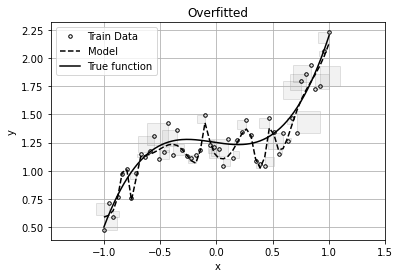

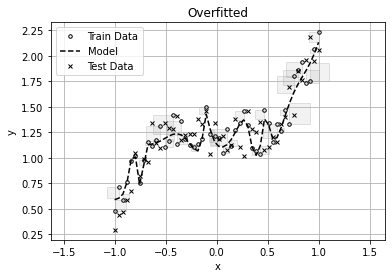

In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

# 학습용 데이터 생성
np.random.seed(327)
x_train = np.linspace(-1,1,50)
y_train = x_train**3 + 0.1 * x_train**2 -0.15 * x_train + 1.0 + 0.5 * np.random.rand(len(x_train))

# 테스트용 데이터 생성
x_test = np.linspace(-1,1,50)
y_test = x_test**3 + 0.1 * x_test**2 -0.15 * x_test + 1.0 + 0.5 * np.random.rand(len(x_test))

features_train = np.array([[xval] for xval in x_train])
labels_train = y_train.reshape(-1, 1)

features_test = np.array([[xval] for xval in x_test])
labels_test = y_test.reshape(-1, 1)

class MyModel(tf.keras.Model):
	def __init__(self, **kwargs):
		super().__init__(**kwargs)
		num_hidden1 = 10 
		num_hidden2 = 5

		self.W1 = tf.Variable(tf.random.normal([1, num_hidden1], seed=624)) 
		self.b1 = tf.Variable(tf.random.normal([num_hidden1], seed=624)) 

		self.W2 = tf.Variable(tf.random.normal([num_hidden1, num_hidden2], seed=624)) 
		self.b2 = tf.Variable(tf.random.normal([num_hidden2], seed=624)) 

		self.W3 = tf.Variable(tf.random.normal([num_hidden2, 1], seed=624)) 
		self.b3 = tf.Variable(tf.random.normal([1], seed=624)) 

	def call(self, x):
		l1 = tf.matmul(x, self.W1) + self.b1
		h1 = tf.nn.sigmoid(l1)

		l2 = tf.matmul(h1, self.W2) + self.b2
		h2 = tf.nn.sigmoid(l2)

		yhat = tf.matmul(h2, self.W3) + self.b3
		return yhat

model = MyModel()

MaxEpochs = 10000
batch_size = 10
lr = 0.05
optimizer = tf.keras.optimizers.Adam(lr)
loss = lambda y, yhat: tf.reduce_mean(tf.square( yhat - y ))

np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

from helper import generate_batches

for epoch in range(MaxEpochs):
	loss_train = loss(labels_train, model(features_train))
	loss_test = loss(labels_test, model(features_test))
	loss_train_history.append(loss_train)
	loss_test_history.append(loss_test)
	
	if epoch % 100 == 0:
		curr_loss = loss(labels_train, model(features_train))
		print(epoch, curr_loss.numpy())
	for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
		with tf.GradientTape() as tape:
			curr_loss = loss(y_batch, model(x_batch))
			gradients = tape.gradient(curr_loss, model.trainable_variables)
			optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def visualize_l2(pred, x_train, y_train, x_test, y_test):
    from matplotlib.patches import Rectangle
    plt.plot(x_train, y_train, '.k', markersize=7, markerfacecolor='none', label='Train Data')
    plt.plot(x_train, pred,  '--k', label='Model')
    xx = np.linspace(-1,1,200)
    yy = xx**3 + 0.1 * xx**2 -0.15 * xx + 1.25
    plt.plot(xx, yy, 'k-', label='True function')
    currentAxis = plt.gca()
    for k, (xx,yy) in enumerate(zip(x_train, y_train)):
        error = pred[k] - yy
        currentAxis.add_patch(Rectangle((xx, yy), 
                                        error, error,
                              alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.xlabel('x')
    plt.ylabel('y')

prediction_values = model(features_train)
final_loss = loss(labels_train, prediction_values)
plt.title("Overfitted")
visualize_l2(prediction_values.numpy().reshape(-1), x_train, y_train, x_test, y_test)
plt.show()

def visualize_l2(pred, x_train, y_train, x_test, y_test):
    from matplotlib.patches import Rectangle
    plt.plot(x_train, y_train, '.k', markersize=7, markerfacecolor='none', label='Train Data')
    plt.plot(x_train, pred,  '--k', label='Model')
    plt.plot(x_test, y_test, 'xk', markersize=4, markerfacecolor='none', label='Test Data')
    currentAxis = plt.gca()
    for k, (xx,yy) in enumerate(zip(x_train, y_train)):
        error = pred[k] - yy
        currentAxis.add_patch(Rectangle((xx, yy), 
                                        error, error,
                              alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.xlabel('x')
    plt.ylabel('y')


plt.title("Overfitted")
visualize_l2(prediction_values.numpy().reshape(-1), x_train, y_train, x_test, y_test)
plt.show()
